# Amazon Customer Review- Sentiment Analysis

### LOAD RELEVANT LIBRARIES AND DATASET

In [1]:
# Import Library

import pandas as pd
import numpy as np

import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns

from gensim.models import Phrases
from gensim.models.phrases import Phraser
import spacy

from wordcloud import WordCloud
from gensim.utils import simple_preprocess

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU,Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Rotim\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Load dataset
data = pd.read_csv("train.csv",header=None, names=["label","title", "review"])

# Display head
data.head()

,label,title,review
0,2,Stuning even for the non-gamer,This sound track was beautiful! It paints the ...
1,2,The best soundtrack ever to anything.,I'm reading a lot of reviews saying that this ...
2,2,Amazing!,This soundtrack is my favorite music of all ti...
3,2,Excellent Soundtrack,I truly like this soundtrack and I enjoy video...
4,2,"Remember, Pull Your Jaw Off The Floor After He...","If you've played the game, you know how divine..."


### PREPROCESSING

In [3]:

# Extract 100,000 samples of each class
label_1 = data[data['label'] == 1].head(100000)
label_2 = data[data['label'] == 2].head(100000)

# 3. Combine and shuffle again
amazon_data = pd.concat([label_1,label_2]).sample(frac=1, random_state=42).reset_index(drop=True)


In [4]:
amazon_data.head()

,label,title,review
0,2,What is a Bitch?,This books is about respect. It's not about th...
1,1,CITY HALL,THE MOVIE WAS SOME WHAT BORING IN THE BEGINNIN...
2,2,INCREDIBLE AND BEAUTIFUL,GREAT MOVIE FOR ADULT AND CHILDREN VERY BEAUTI...
3,1,"Horrible, unsexy, boring mess",This was my first time reading this author and...
4,1,It was very boring!,I had trouble staying awake for this one. I wa...


In [5]:
# Data Shape
print('Dataframe shape: ', amazon_data.shape)

Dataframe shape:  (200000, 3)


In [6]:
# Define function to remove stop words
def preprocess(sentences, language='english'):
    stop_words = set(stopwords.words(language))
    for sentence in sentences:
        yield [word for word in simple_preprocess(sentence, deacc=False) if word not in stop_words]

        
data= amazon_data['review'].to_list() # Convert review column to list of reviews

data_words= list(preprocess(data)) # Apply function to remove stopword from review

In [7]:
# Train bigram model
bigram = Phrases(data_words, min_count=5, threshold=100)
bigram_mod = Phraser(bigram)

# Train trigram model on bigram-transformed data
trigram = Phrases(bigram_mod[data_words], threshold=100)
trigram_mod = Phraser(trigram)

# Create bigram & trigram from reviews
data_words_big = [bigram_mod[doc] for doc in data_words]        

data_words_trig = [trigram_mod[bigram_mod[doc]] for doc in data_words]

In [79]:
# Load spaCy English model with only POS tagger
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

# Define a function to lemmatise review words
def lemmatisation(texts, allowed_postags=["NOUN", "ADJ", "VERB", "ADV"]):
    lemmatized_texts = []
    for doc in texts:
        doc_nlp = nlp(" ".join(doc))
        lemmatized_doc = [token.lemma_ for token in doc_nlp if token.pos_ in allowed_postags]
        lemmatized_texts.append(lemmatized_doc)
    return lemmatized_texts

# Apply lemmatisation function on trigrams 
data_lemmatized = lemmatisation(data_words_trig)

print('data_lemmatized[:1]', data_lemmatized[:1])

data_lemmatized[:1] [['book', 'respect', 'mean', 'bitch', 'type', 'layer', 'disturb', 'personality', 'veneer', 'respect', 'respect', 'hack', 'self', 'respect', 'male', 'associate', 'really', 'technique', 'tactic', 'plenty', 'provide', 'well', 'feel', 'entitlement', 'respect', 'relationship', 'advice', 'make', 'sense', 'read', 'book', 'require', 'respect']]


In [81]:
# Join tokens into full strings
amazon_data["lemmatised_review"] = [" ".join(doc) for doc in data_lemmatized]

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(amazon_data["lemmatised_review"], amazon_data["label"], test_size=0.2, random_state=42)

# Vectorize the review text
vectorizer = CountVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)


### Wordcloud

In [109]:
# Define a function
def getWordCloud(hashtags, max_font_size=40, output_file='wordcloud_all.pdf'):
    """
    Generate and display a word cloud from a list of strings.
    - hashtags: list of strings (pre-joined lemmatized words)
    - max_font_size: max font size for the largest word
    - output_file: path to save the word cloud image (PDF)
    """
    text = ' '.join(hashtags)
    
    # Generate word cloud
    wordcloud = WordCloud(max_font_size=max_font_size, background_color='white').generate(text)
    
    # Plot
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.savefig(output_file, dpi=500)
    plt.show()

Positive Review Wordcloud


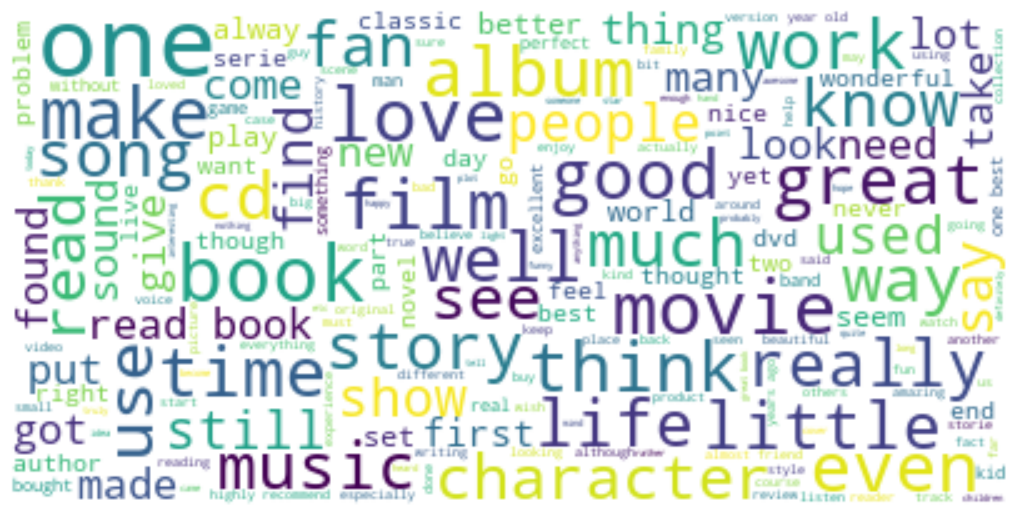

None
Negative Review Wordcloud


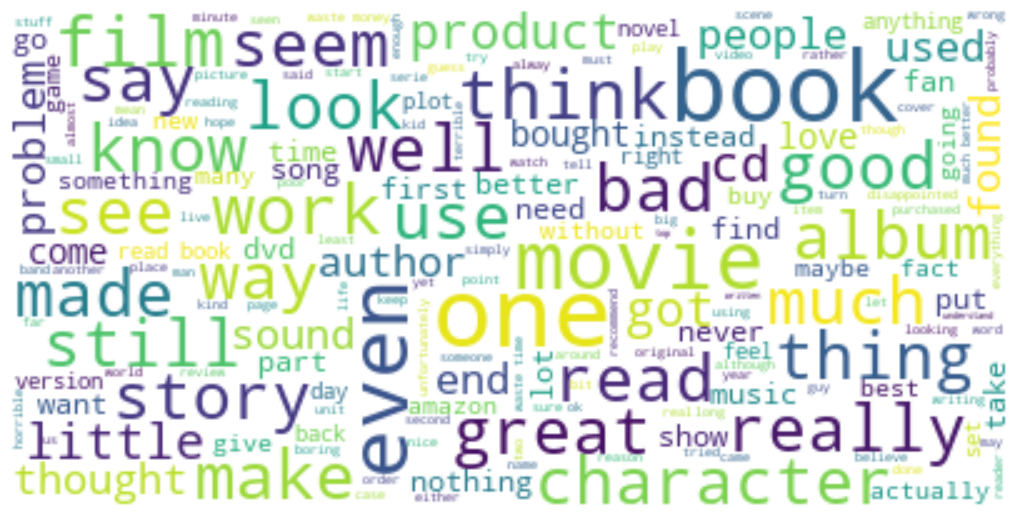

None


In [127]:
# Create word cloud for positive and negative reviews
amazon_data_=amazon_data.copy()
amazon_data_['lemmatised_review']= data_words

# Extract reviews from each class to a variable
postive_review= amazon_data_[amazon_data_['label']==2]["lemmatised_review"] # Positive
negative_review= amazon_data_[amazon_data_['label']==1]["lemmatised_review"] # Negative

# Generate wordcloud
strings_1 = [' '.join(doc) for doc in postive_review]
print('Positive Review Wordcloud')
print(getWordCloud(strings_1))


strings_2 = [' '.join(doc) for doc in negative_review]
print('Negative Review Wordcloud')
print(getWordCloud(strings_2))

### NAIVE BAYE'S Classifier

In [82]:
# Train Multinomial Naive Bayes
clf = MultinomialNB()
clf.fit(X_train_vec, y_train)

# Predict and evaluate
naive_y_pred = clf.predict(X_test_vec)

print("Accuracy:", accuracy_score(y_test, naive_y_pred))
print("\nClassification Report:\n", classification_report(y_test, naive_y_pred))

Accuracy: 0.829575

Classification Report:
               precision    recall  f1-score   support

           1       0.83      0.83      0.83     20096
           2       0.83      0.83      0.83     19904

    accuracy                           0.83     40000
   macro avg       0.83      0.83      0.83     40000
weighted avg       0.83      0.83      0.83     40000



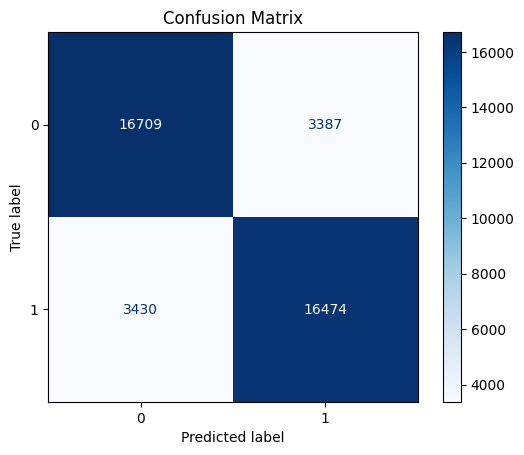

In [85]:
# Obtain Confusion
cm = confusion_matrix(y_test, naive_y_pred)

# Plot Confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


HYPERPARAMETER TUNNING OF NAIVE BAYE'S

In [83]:
# alpha= 0.7
clf = MultinomialNB(alpha=0.7)
clf.fit(X_train_vec, y_train)

# Predict and evaluate
naive_y_pred2 = clf.predict(X_test_vec)

print("Accuracy:", accuracy_score(y_test, naive_y_pred2))
print("\nClassification Report:\n", classification_report(y_test, naive_y_pred2))

Accuracy: 0.829225

Classification Report:
               precision    recall  f1-score   support

           1       0.83      0.83      0.83     20096
           2       0.83      0.83      0.83     19904

    accuracy                           0.83     40000
   macro avg       0.83      0.83      0.83     40000
weighted avg       0.83      0.83      0.83     40000



### Support Vector Machine

In [86]:
# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_train_vecc = vectorizer.fit_transform(X_train)
X_test_vecc = vectorizer.transform(X_test)


In [87]:

svm_model = LinearSVC()  # Create an instance of linearSVM
svm_model.fit(X_train_vecc, y_train) # fit model

# Predict and evaluate
svm_y_pred = svm_model.predict(X_test_vecc)

print("Accuracy:", accuracy_score(y_test, svm_y_pred))
print("\nClassification Report:\n", classification_report(y_test, svm_y_pred))

C:\Users\Rotim\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Accuracy: 0.855025

Classification Report:
               precision    recall  f1-score   support

           1       0.86      0.85      0.85     20096
           2       0.85      0.86      0.86     19904

    accuracy                           0.86     40000
   macro avg       0.86      0.86      0.86     40000
weighted avg       0.86      0.86      0.86     40000



#### Hyperparameter Tunning

1

In [88]:
# loss= 'hinge'
# C= 1
svm_model2 = LinearSVC(penalty='l2', loss='hinge', C=1)
svm_model2.fit(X_train_vecc, y_train)

# Predict and evaluate
svm_y_pred2 = svm_model2.predict(X_test_vecc)

print("Accuracy:", accuracy_score(y_test, svm_y_pred2))
print("\nClassification Report:\n", classification_report(y_test, svm_y_pred2))

C:\Users\Rotim\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Accuracy: 0.854225

Classification Report:
               precision    recall  f1-score   support

           1       0.86      0.85      0.85     20096
           2       0.85      0.86      0.85     19904

    accuracy                           0.85     40000
   macro avg       0.85      0.85      0.85     40000
weighted avg       0.85      0.85      0.85     40000



C:\Users\Rotim\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


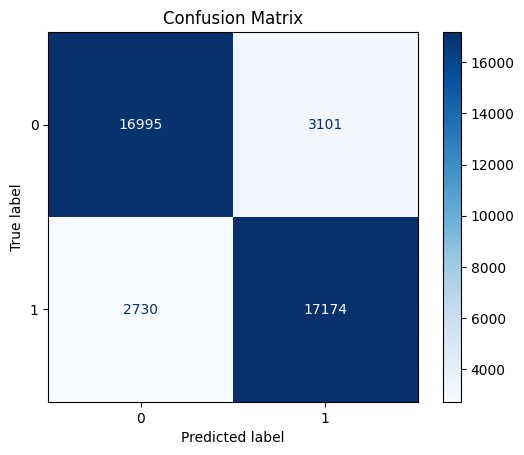

In [92]:
# Obtain Confusion
cm = confusion_matrix(y_test, svm_y_pred2)

# Plot Confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


2

In [90]:
# loss= 'squared_hinge'
# C= 0.01
svm_model3 = LinearSVC(penalty='l2', loss='squared_hinge',C=0.01)
svm_model3.fit(X_train_vecc, y_train)

# Predict and evaluate
svm_y_pred3 = svm_model3.predict(X_test_vecc)

print("Accuracy:", accuracy_score(y_test, svm_y_pred3))
print("\nClassification Report:\n", classification_report(y_test, svm_y_pred3))

C:\Users\Rotim\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Accuracy: 0.844175

Classification Report:
               precision    recall  f1-score   support

           1       0.85      0.84      0.84     20096
           2       0.84      0.85      0.84     19904

    accuracy                           0.84     40000
   macro avg       0.84      0.84      0.84     40000
weighted avg       0.84      0.84      0.84     40000




### DEEP LEARNING PREPROCESSING

### Preprocessing

Plotting histogram of reviews word count and calculating it percentiles for all reviews to determine most suitable Maxlenn value for deep learning model

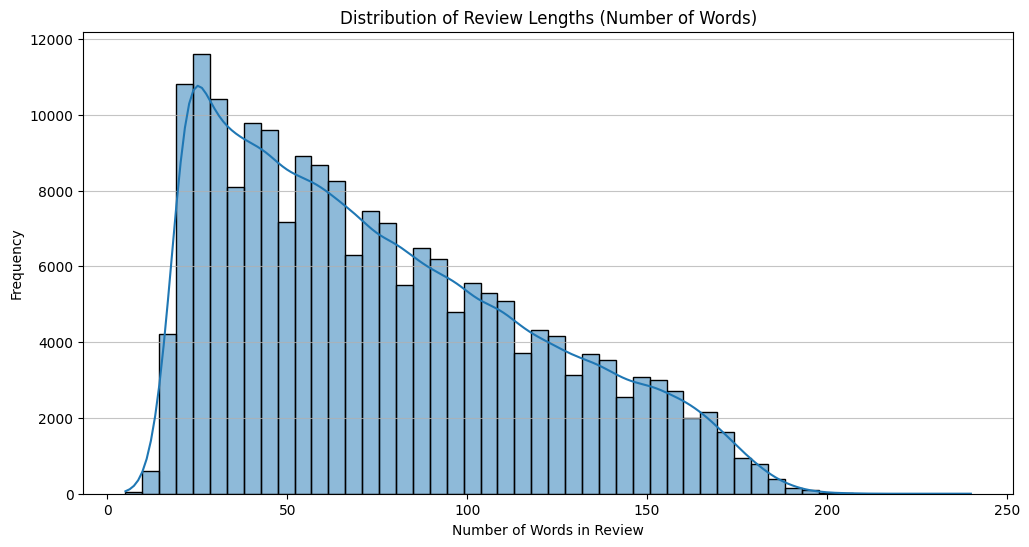

--- Review Length Statistics ---
count    200000.000000
mean         75.769805
std          42.721499
min           5.000000
25%          40.000000
50%          68.000000
75%         106.000000
max         240.000000
Name: review, dtype: float64
75th percentile: 106 words
80th percentile: 116 words
85th percentile: 127 words
90th percentile: 141 words
95th percentile: 157 words
99th percentile: 176 words


In [6]:
# Calculate the length of each review (number of words)
# Split by space to count words.
texttt = amazon_data['review'].apply(lambda x: len(x.split()))

# Plot the histogram of review lengths
plt.figure(figsize=(12, 6))
sns.histplot(texttt, bins=50, kde=True) # bins can be adjusted
plt.title('Distribution of Review Lengths (Number of Words)')
plt.xlabel('Number of Words in Review')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

# Calculate Descriptive Statistics and Percentiles
print("- Review Length Statistics -")
print(texttt.describe())

# Calculate specific percentiles to help determine maxlen
percentiles = [75, 80, 85, 90, 95, 99]
for p in percentiles:
    value = np.percentile(texttt, p)
    print(f"{p}th percentile: {int(value)} words")

# 90th percentile of the review is <= 141 words, therefore a maxlen of 150 words is used

In [5]:
# Define some hyperparameters
num_wordss=50000 
input_dimm=50000
output_dimm= 64
maxlenn= 150

In [7]:
# Prepare data
texts = amazon_data["review"].astype(str).tolist()
labels = amazon_data["label"].tolist()

# Encode labels if needed
le = LabelEncoder()
labels = le.fit_transform(labels)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.2, random_state=42)

# Tokenize
tokenizer = Tokenizer(num_words=num_wordss, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad sequences
X_train_pad = pad_sequences(X_train_seq, maxlen=maxlenn, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=maxlenn, padding='post', truncating='post')

# Convert labels to numpy arrays
y_train = np.array(y_train)
y_test = np.array(y_test)

### LSTM Model

In [9]:
# Define LSTM model
model_1 = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=input_dimm, output_dim=64, input_length=maxlenn),
    tf.keras.layers.LSTM(64),  # No return_sequences needed unless stacking
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model
model_1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


# Define EarlyStopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# Train the model
history = model_1.fit(
    X_train_pad, y_train, validation_split=0.1, epochs=4, batch_size=32, callbacks=[early_stop]
)

Epoch 1/4
4500/4500 [==============================] - 502s 111ms/step - loss: 0.6536 - accuracy: 0.5883 - val_loss: 0.6419 - val_accuracy: 0.6458
Epoch 2/4
4500/4500 [==============================] - 502s 112ms/step - loss: 0.5963 - accuracy: 0.6505 - val_loss: 0.3517 - val_accuracy: 0.8494
Epoch 3/4
4500/4500 [==============================] - 521s 116ms/step - loss: 0.2727 - accuracy: 0.8874 - val_loss: 0.2548 - val_accuracy: 0.8948
Epoch 4/4
4500/4500 [==============================] - 562s 125ms/step - loss: 0.1924 - accuracy: 0.9256 - val_loss: 0.2596 - val_accuracy: 0.8963


In [10]:
# Evaluate
loss_1, acc_1 = model_1.evaluate(X_test_pad, y_test)
print(f"Test Accuracy: {acc:.2f}")

1250/1250 [==============================] - 36s 29ms/step - loss: 0.2502 - accuracy: 0.9005
Test Accuracy: 0.90


1250/1250 [==============================] - 44s 34ms/step
Accuracy: 0.900475

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.92      0.90     20096
           1       0.91      0.88      0.90     19904

    accuracy                           0.90     40000
   macro avg       0.90      0.90      0.90     40000
weighted avg       0.90      0.90      0.90     40000



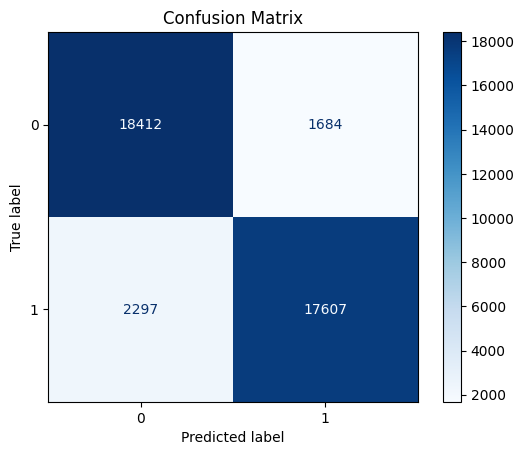

In [11]:
# Predict and evaluate
lstm_y_pred = model_1.predict(X_test_pad)
lstm_y_pred = (lstm_y_pred > 0.5).astype("int32")

print("Accuracy:", accuracy_score(y_test, lstm_y_pred))
print("\nClassification Report:\n", classification_report(y_test, lstm_y_pred))
# Obtain Confusion
cm = confusion_matrix(y_test, lstm_y_pred)

# Plot Confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


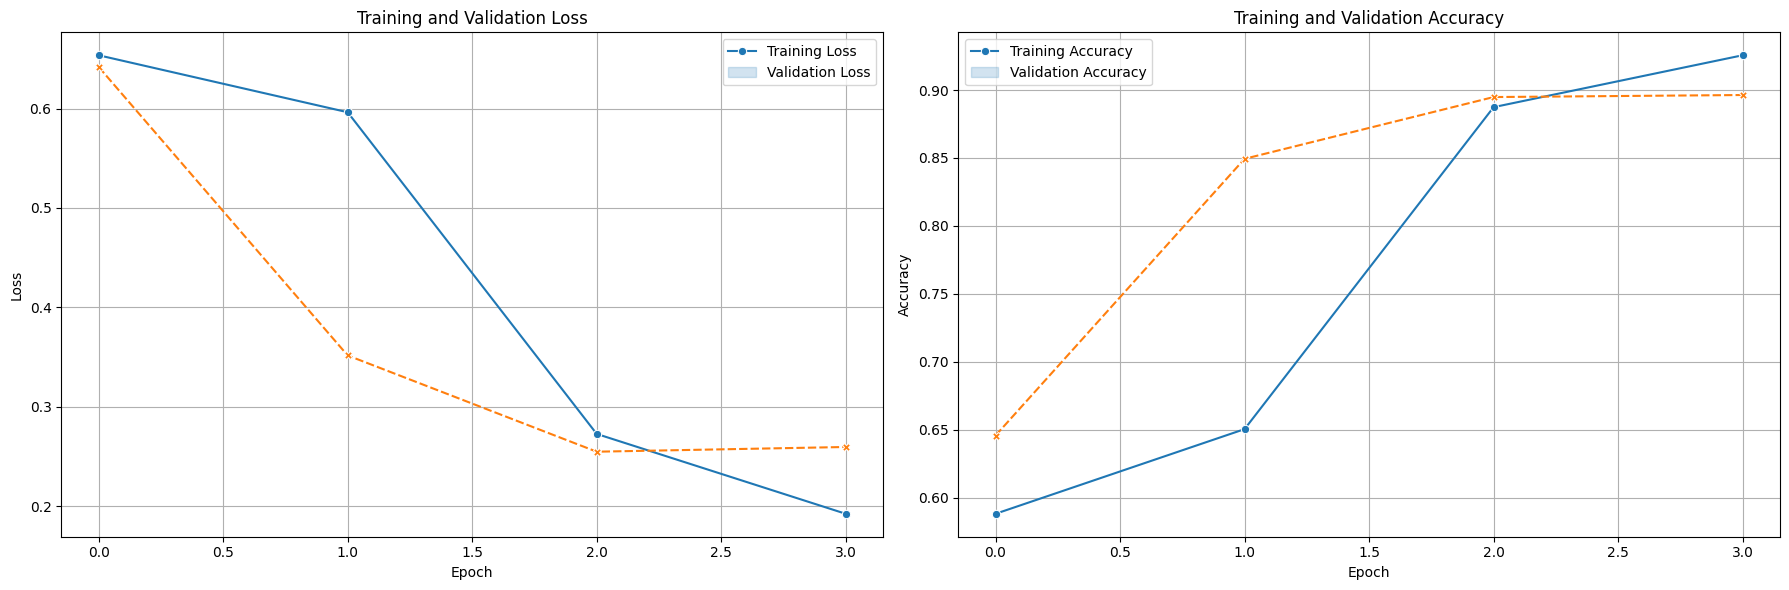

In [15]:
# Extract History to dataframe 
history_df = pd.DataFrame(history.history)
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot Loss
sns.lineplot(ax=axes[0], data=history_df[['loss', 'val_loss']], markers=True)
axes[0].set_title('Training and Validation Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].grid(True)
axes[0].legend(['Training Loss', 'Validation Loss'])

# Plot Accuracy
sns.lineplot(ax=axes[1], data=history_df[['accuracy', 'val_accuracy']], markers=True)
axes[1].set_title('Training and Validation Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].grid(True)
axes[1].legend(['Training Accuracy', 'Validation Accuracy'])

plt.tight_layout() # Adjust layout to prevent overlap
plt.show()

Hyperparameter Tunning 1
-include dropout

In [67]:
# Define LSTM model
model_2 = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=input_dimm, output_dim=64, input_length=maxlenn),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model
model_2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


# Define EarlyStopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# Train the model
history_2 = model_2.fit(
    X_train_pad, y_train, validation_split=0.1, epochs=6, batch_size=32, callbacks=[early_stop]
)

Epoch 1/6
4500/4500 [==============================] - 592s 131ms/step - loss: 0.6830 - accuracy: 0.5316 - val_loss: 0.4420 - val_accuracy: 0.8041
Epoch 2/6
4500/4500 [==============================] - 571s 127ms/step - loss: 0.3005 - accuracy: 0.8780 - val_loss: 0.2523 - val_accuracy: 0.8977
Epoch 3/6
4500/4500 [==============================] - 535s 119ms/step - loss: 0.2046 - accuracy: 0.9224 - val_loss: 0.2584 - val_accuracy: 0.9000
Epoch 4/6
4500/4500 [==============================] - 548s 122ms/step - loss: 0.1506 - accuracy: 0.9456 - val_loss: 0.2703 - val_accuracy: 0.8974


In [68]:
# Evaluate
loss, acc = model_2.evaluate(X_test_pad, y_test)
print(f"Test Accuracy: {acc:.2f}")

1250/1250 [==============================] - 42s 33ms/step - loss: 0.2491 - accuracy: 0.8989
Test Accuracy: 0.90


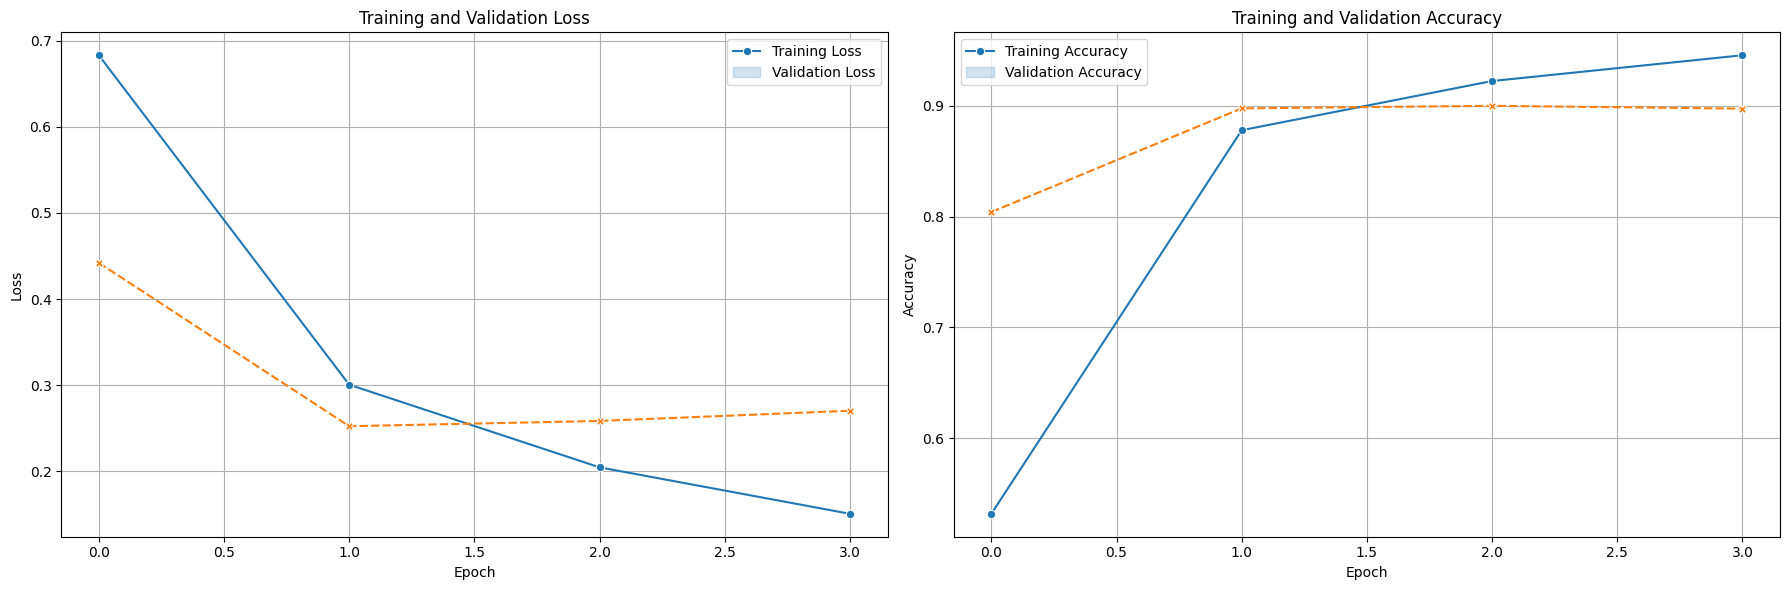

In [69]:
history_df = pd.DataFrame(history_2.history)
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot Loss
sns.lineplot(ax=axes[0], data=history_df[['loss', 'val_loss']], markers=True)
axes[0].set_title('Training and Validation Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].grid(True)
axes[0].legend(['Training Loss', 'Validation Loss'])

# Plot Accuracy
sns.lineplot(ax=axes[1], data=history_df[['accuracy', 'val_accuracy']], markers=True)
axes[1].set_title('Training and Validation Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].grid(True)
axes[1].legend(['Training Accuracy', 'Validation Accuracy'])

plt.tight_layout() # Adjust layout to prevent overlap
plt.show()

In [70]:
# Tunning, add dropout to Dense layer*
# Define LSTM model
model_3 = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=input_dimm, output_dim=64, input_length=maxlenn),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Binary classification
])

# Custom optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
# Compile the model
model_3.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Define EarlyStopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# Train the model
history_3 = model_3.fit(
    X_train_pad, y_train, validation_split=0.1, epochs=10, batch_size=64, callbacks=[early_stop]
)

Epoch 1/10
2250/2250 [==============================] - 441s 194ms/step - loss: 0.6934 - accuracy: 0.5009 - val_loss: 0.6932 - val_accuracy: 0.4927
Epoch 2/10
2250/2250 [==============================] - 411s 183ms/step - loss: 0.6436 - accuracy: 0.5948 - val_loss: 0.5029 - val_accuracy: 0.7670
Epoch 3/10
2250/2250 [==============================] - 437s 194ms/step - loss: 0.4692 - accuracy: 0.7956 - val_loss: 0.4222 - val_accuracy: 0.8140
Epoch 4/10
2250/2250 [==============================] - 419s 186ms/step - loss: 0.4055 - accuracy: 0.8316 - val_loss: 0.3989 - val_accuracy: 0.8297
Epoch 5/10
2250/2250 [==============================] - 396s 176ms/step - loss: 0.3690 - accuracy: 0.8501 - val_loss: 0.3955 - val_accuracy: 0.8382
Epoch 6/10
2250/2250 [==============================] - 410s 182ms/step - loss: 0.3397 - accuracy: 0.8632 - val_loss: 0.3575 - val_accuracy: 0.8483
Epoch 7/10
2250/2250 [==============================] - 463s 206ms/step - loss: 0.3175 - accuracy: 0.8731 - val_

In [76]:
# Evaluate
loss, acc = model_3.evaluate(X_test_pad, y_test)
print(f"Test Accuracy: {acc:.2f}")

1250/1250 [==============================] - 55s 43ms/step - loss: 0.3497 - accuracy: 0.8542
Test Accuracy: 0.85


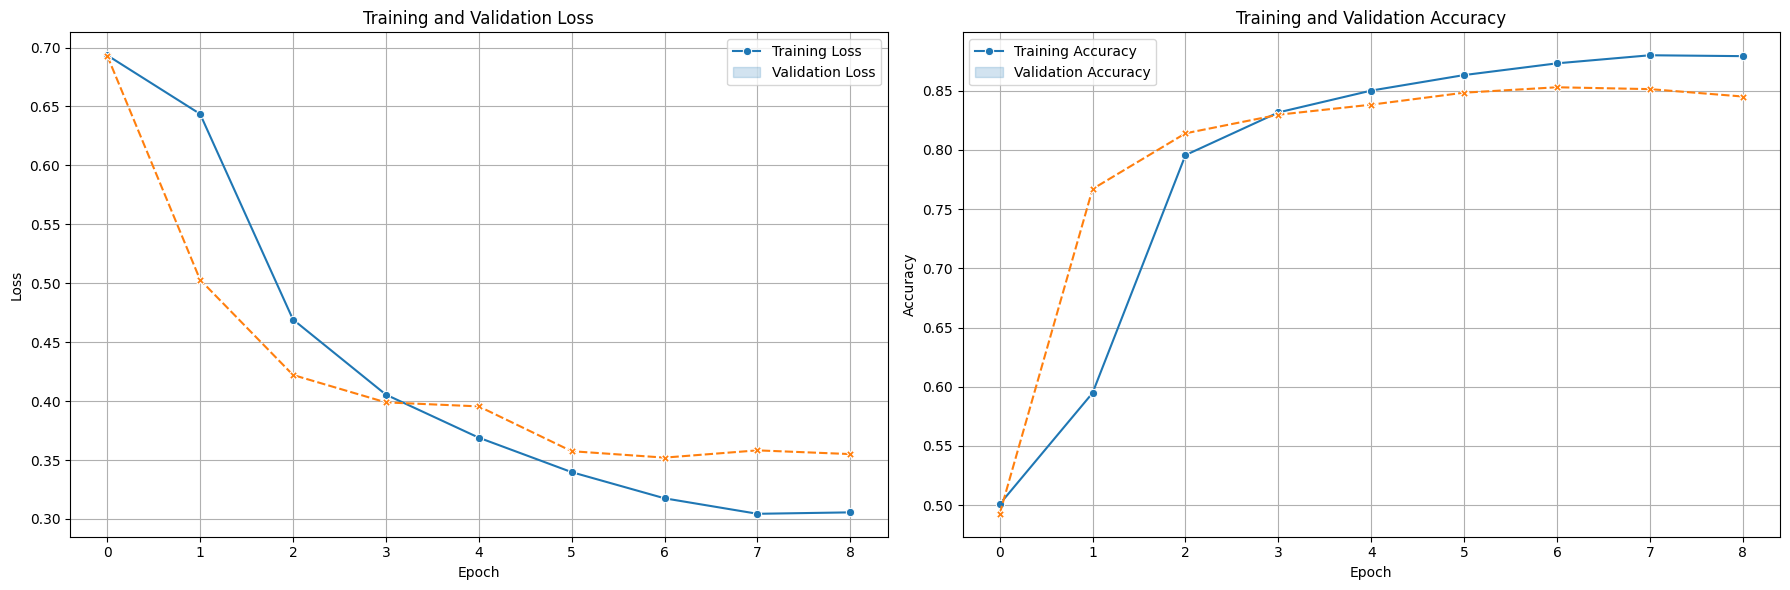

In [77]:
history_df = pd.DataFrame(history_3.history)
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot Loss
sns.lineplot(ax=axes[0], data=history_df[['loss', 'val_loss']], markers=True)
axes[0].set_title('Training and Validation Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].grid(True)
axes[0].legend(['Training Loss', 'Validation Loss'])

# Plot Accuracy
sns.lineplot(ax=axes[1], data=history_df[['accuracy', 'val_accuracy']], markers=True)
axes[1].set_title('Training and Validation Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].grid(True)
axes[1].legend(['Training Accuracy', 'Validation Accuracy'])

plt.tight_layout() # Adjust layout to prevent overlap
plt.show()

In [23]:
# Define LSTM model
model_4 = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=input_dimm, output_dim=64, input_length=maxlenn),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model
model_4.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


# Train the model
history_4 = model_4.fit(
    X_train_pad, y_train, validation_split=0.1, epochs=4, batch_size=64, callbacks=[early_stop]
)

Epoch 1/4
2250/2250 [==============================] - 500s 193ms/step - loss: 0.6833 - accuracy: 0.5607 - val_loss: 0.6718 - val_accuracy: 0.6031
Epoch 2/4
2250/2250 [==============================] - 365s 162ms/step - loss: 0.6537 - accuracy: 0.6333 - val_loss: 0.6058 - val_accuracy: 0.6938
Epoch 3/4
2250/2250 [==============================] - 365s 162ms/step - loss: 0.6583 - accuracy: 0.5904 - val_loss: 0.6175 - val_accuracy: 0.6749
Epoch 4/4
2250/2250 [==============================] - 389s 173ms/step - loss: 0.5961 - accuracy: 0.6677 - val_loss: 0.5102 - val_accuracy: 0.7567


In [33]:
# Evaluate
loss, acc = model_4.evaluate(X_test_pad, y_test)
print(f"Test Accuracy: {acc:.2f}")

1250/1250 [==============================] - 40s 32ms/step - loss: 0.4996 - accuracy: 0.7615
Test Accuracy: 0.76


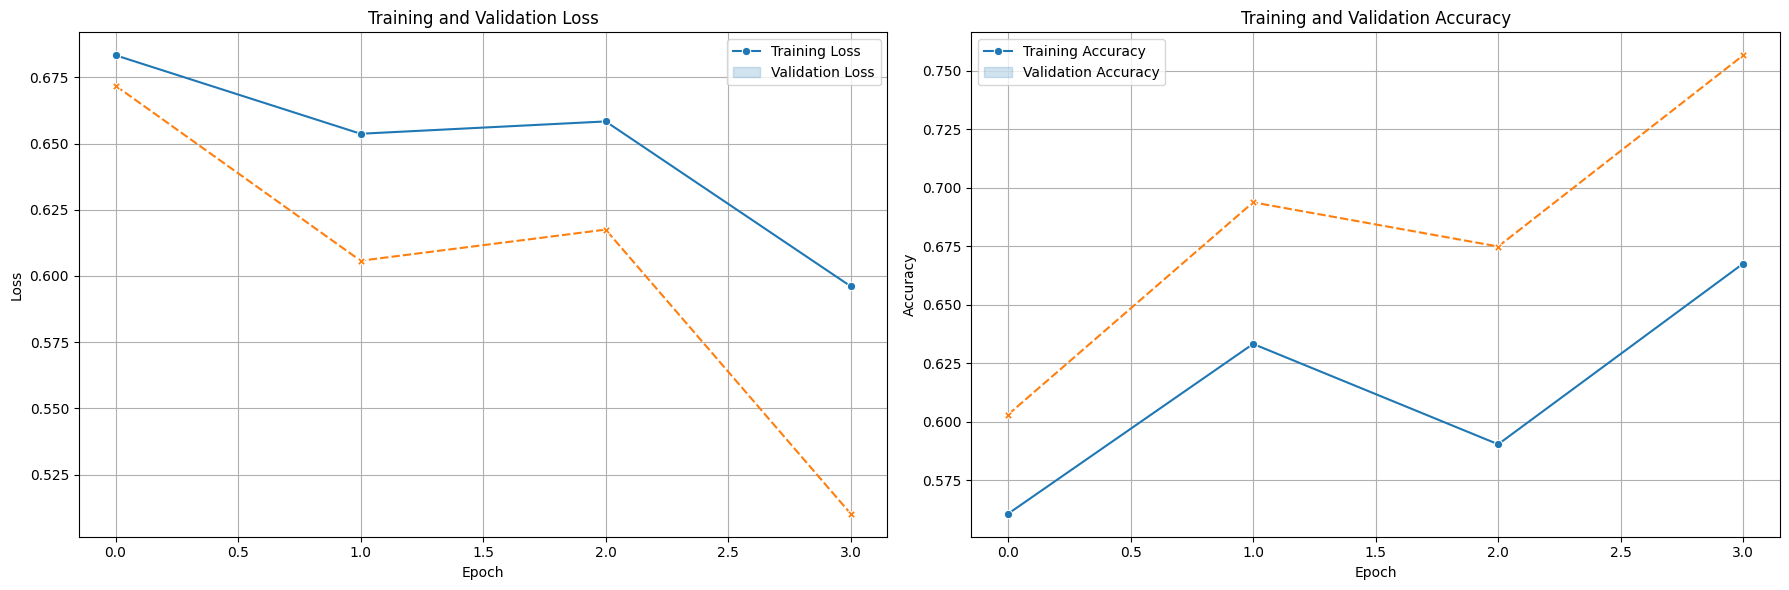

In [25]:
history_df = pd.DataFrame(history_4.history)
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot Loss
sns.lineplot(ax=axes[0], data=history_df[['loss', 'val_loss']], markers=True)
axes[0].set_title('Training and Validation Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].grid(True)
axes[0].legend(['Training Loss', 'Validation Loss'])

# Plot Accuracy
sns.lineplot(ax=axes[1], data=history_df[['accuracy', 'val_accuracy']], markers=True)
axes[1].set_title('Training and Validation Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].grid(True)
axes[1].legend(['Training Accuracy', 'Validation Accuracy'])

plt.tight_layout() # Adjust layout to prevent overlap
plt.show()

#### GRU Model


In [30]:
# Define GRU model
model_gru1 = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=input_dimm, output_dim=64, input_length=maxlenn),

    # GRU Layer: but often simpler gates
    tf.keras.layers.GRU(64), # Using 64 units for consistency with LSTM example
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Binary classification output
])

# Compile the GRU model
model_gru1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


# Define EarlyStopping callback (re-using the same settings)
early_stop_gru = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# Train the model
history_gru1 = model_gru1.fit(
    X_train_pad, y_train, validation_split=0.1, epochs=3, callbacks=[early_stop]
)

Epoch 1/3
4500/4500 [==============================] - 472s 104ms/step - loss: 0.5062 - accuracy: 0.6869 - val_loss: 0.2675 - val_accuracy: 0.8888
Epoch 2/3
4500/4500 [==============================] - 373s 83ms/step - loss: 0.2221 - accuracy: 0.9117 - val_loss: 0.2376 - val_accuracy: 0.9049
Epoch 3/3
4500/4500 [==============================] - 359s 80ms/step - loss: 0.1534 - accuracy: 0.9428 - val_loss: 0.2527 - val_accuracy: 0.9049


In [36]:
# Evaluate
loss_2, acc_2 = model_gru1.evaluate(X_test_pad, y_test)
print(f"Test Accuracy: {acc_2:.2f}")

1250/1250 [==============================] - 35s 28ms/step - loss: 0.2489 - accuracy: 0.9040
Test Accuracy: 0.90


1250/1250 [==============================] - 31s 25ms/step
Accuracy: 0.90405

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.92      0.91     20096
           1       0.91      0.89      0.90     19904

    accuracy                           0.90     40000
   macro avg       0.90      0.90      0.90     40000
weighted avg       0.90      0.90      0.90     40000



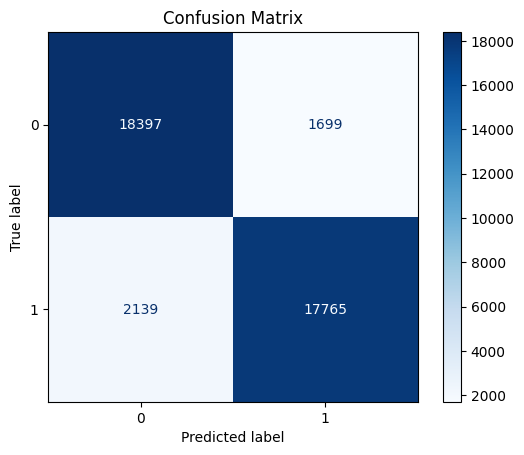

In [37]:
# Predict and evaluate
gru_y_pred = model_gru1.predict(X_test_pad)
gru_y_pred = (gru_y_pred > 0.5).astype("int32")

print("Accuracy:", accuracy_score(y_test, gru_y_pred))
print("\nClassification Report:\n", classification_report(y_test, gru_y_pred))
# Obtain Confusion
cm = confusion_matrix(y_test, gru_y_pred)

# Plot Confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [31]:
# Define GRU model
model_gru2 = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=input_dimm, output_dim=64, input_length=maxlenn),

    # GRU Layer: but often simpler gates
    tf.keras.layers.GRU(64), # Using 64 units for consistency with LSTM example
    tf.keras.layers.Dropout(0.2), # Dropout on the GRU's summary vector
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Binary classification output
])

# Compile the GRU model
model_gru2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define EarlyStopping callback
early_stop_gru = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# Train the model
history_gru2 = model_gru2.fit(
    X_train_pad, y_train, validation_split=0.1, epochs=3, callbacks=[early_stop]
)

Epoch 1/3
4500/4500 [==============================] - 371s 82ms/step - loss: 0.5267 - accuracy: 0.6694 - val_loss: 0.2669 - val_accuracy: 0.8928
Epoch 2/3
4500/4500 [==============================] - 358s 79ms/step - loss: 0.2281 - accuracy: 0.9104 - val_loss: 0.2334 - val_accuracy: 0.9091
Epoch 3/3
4500/4500 [==============================] - 357s 79ms/step - loss: 0.1573 - accuracy: 0.9415 - val_loss: 0.2439 - val_accuracy: 0.9026


In [32]:
# Define GRU model
model_gru3 = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=input_dimm, output_dim=64, input_length=maxlenn),

    # GRU Layer: but often simpler gates
    tf.keras.layers.GRU(64), # Using 64 units for consistency with LSTM example
    tf.keras.layers.Dropout(0.2), # Dropout on the GRU's summary vector
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Binary classification output
])

# Custom optimizer (using the same as your LSTM for fair comparison initially)
optimizer_gru = tf.keras.optimizers.Adam(learning_rate=0.01)

# Compile the GRU model
model_gru3.compile(optimizer=optimizer_gru, loss='binary_crossentropy', metrics=['accuracy'])

# Define EarlyStopping callback
early_stop_gru = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# Train the model
history_gru3 = model_gru3.fit(
    X_train_pad, y_train, validation_split=0.1, epochs=6, batch_size=32, callbacks=[early_stop_gru]
)

Epoch 1/6
4500/4500 [==============================] - 372s 82ms/step - loss: 0.5237 - accuracy: 0.7283 - val_loss: 0.4203 - val_accuracy: 0.8123
Epoch 2/6
4500/4500 [==============================] - 19891s 4s/step - loss: 0.5361 - accuracy: 0.7343 - val_loss: 0.5135 - val_accuracy: 0.7544
Epoch 3/6
4500/4500 [==============================] - 392s 87ms/step - loss: 0.4973 - accuracy: 0.7658 - val_loss: 0.4656 - val_accuracy: 0.7796


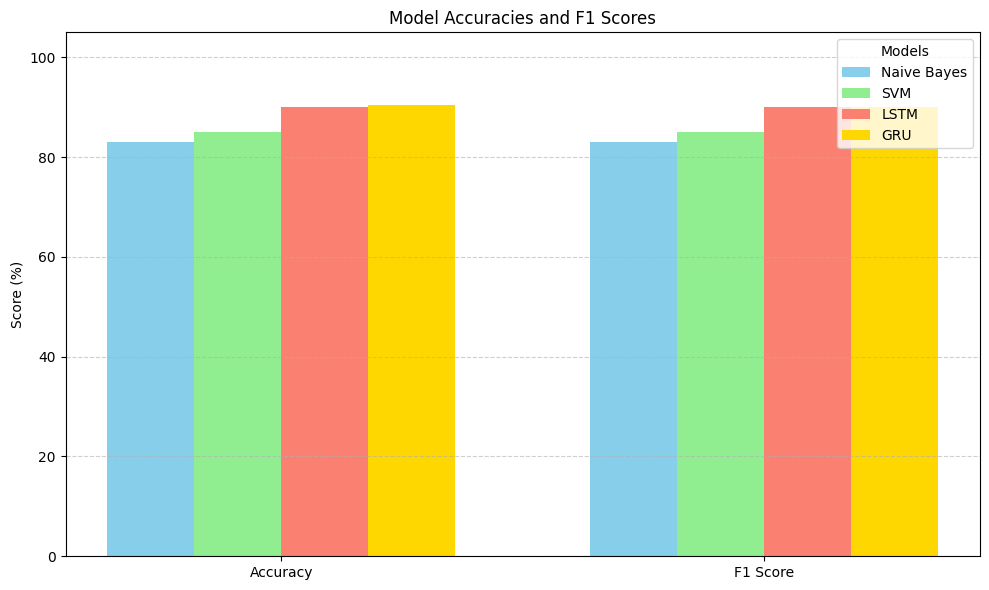

In [65]:
# Model names and scores
# Put model names into a list
model_names = ['Naive Bayes', 'SVM', 'LSTM', 'GRU']
accuracies = [83, 85.5, 90, 90.4]
f1_scores = [83, 86, 90, 90]

# X-axis positions: one group for Accuracy, one for F1
x_labels = ['Accuracy', 'F1 Score']
x = np.arange(len(x_labels))  # [0, 1]


plt.figure(figsize=(10, 6))
# Plot each model's bar in each group
for i, (acc, f1) in enumerate(zip(accuracies, f1_scores)):
    plt.bar(x[0] + offsets[i]*bar_width, acc, width=bar_width, label=model_names[i] if x[0] == 0 else "", color=colors[i])
    plt.bar(x[1] + offsets[i]*bar_width, f1, width=bar_width, color=colors[i])

# Formatting
plt.xticks(x, x_labels)
plt.ylabel('Score (%)')
plt.title('Model Accuracies and F1 Scores')
plt.ylim(0, 105)
plt.legend(title='Models')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()
